In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from sklearn.datasets import make_classification
#import pandas as pd
#import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from IPython import display
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from collections import defaultdict

import sklearn.datasets

torch.manual_seed(1)
np.random.seed(7)
#sns.set(style="white", palette="muted", color_codes=True, context="talk")

%matplotlib inline
print(torch.__version__) 

1.7.1


In [2]:
import time
from torchvision import datasets, transforms


# Dataset and Model Definition

In [3]:
BATCH_SIZE=512

In [4]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.flatten(x)),
    #transforms.Normalize((0.1307,), (0.3081,))
    ])

dataset1 = datasets.MNIST('data', train=True, download=True,
                   transform=transform)
dataset2 = datasets.MNIST('data', train=False,
                   transform=transform)

train_loader = torch.utils.data.DataLoader(dataset1, batch_size=BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=BATCH_SIZE)
n_features = 784
n_classes = 10

In [5]:
n_hidden = 256
class Classifier(nn.Module):
    def __init__(self, n_features, n_hidden=n_hidden):
        super(Classifier, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(n_features, 400, bias=False),
            nn.ReLU(),
            nn.Linear(400, 400, bias=False),
            nn.ReLU(),
            nn.Linear(400, 10, bias=False),
            nn.ReLU(),
            nn.LogSoftmax()
        )

    def forward(self, x):
        return self.network(x)

In [6]:
def accuracy(model, X, y):
    Xt = torch.from_numpy(X).float()
    yt = torch.from_numpy(y).long()
    outputs = model(Xt)
    y_hat = [1 if o>.5 else 0 for o in outputs]
    accuracy = np.sum(y_hat == y) / len(y)
    return accuracy

# Training

In [7]:
def make_plot(info, key, title):
    plt.plot(info[key]);
    plt.title(title)
    plt.show()

In [8]:
UPSTREAM_GRAD_BOUND = 0.00001
INPUT_BOUND = 0.5

In [9]:
def l2_clip(t, C):
    dims = tuple(range(1, len(t.shape)))
    norm = t.norm(dim=dims, keepdim=True).expand(t.shape)
    clipped = torch.where(norm > C, C*(t/norm), t)
    new_norms = clipped.norm(dim=dims)

    return clipped

In [10]:
grad_maxes = []
def clamp_grad(self, grad_input, grad_output):
    if isinstance(self, nn.Linear):
        upstream_g, g_weights = grad_input
        if upstream_g == None:
            return grad_input
        else:
            grad_maxes.append(upstream_g.abs().max())

            return (l2_clip(upstream_g, UPSTREAM_GRAD_BOUND), g_weights)
    elif isinstance(self, nn.ReLU):
        grad_maxes.append(grad_input[0].abs().max())

        return (l2_clip(grad_input[0], UPSTREAM_GRAD_BOUND),)
    else:
        return None

In [11]:
input_maxes = []
def clamp_input(self, input):
    input_maxes.append(input[0].abs().max())
    return tuple([l2_clip(x, INPUT_BOUND) for x in input])

In [12]:
def zcdp_eps(rho, delta):
    return rho + 2*np.sqrt(rho*np.log(1/delta))

In [13]:
def run_experiment(epsilon, epochs, add_noise=False):
    model = Classifier(n_features=n_features)
    model_criterion = nn.NLLLoss() 
    model_optimizer = optim.Adam(model.parameters(), lr=0.01)#, weight_decay=0.0001)
    rho_i = 0.000001
    total_rho = 0
    
    for x in model.network:
        x.register_backward_hook(clamp_grad)
        x.register_forward_pre_hook(clamp_input)
    
    sensitivities = []
    norms = []
    decays = []
    losses = []

    for epoch in range(epochs):
        for x_batch_train, y_batch_train in train_loader:
            model_optimizer.zero_grad()
            #inp = Variable(x_batch_train, requires_grad=True)
            outputs = model.forward(x_batch_train)
            loss = model_criterion(outputs, y_batch_train)
            losses.append(loss)
            loss.backward()
            
            for i, layer in enumerate(model.network):
                if isinstance(layer, nn.Linear):
                    ps = list(layer.parameters())
                    weights = ps[0]
                    #bias = ps[1]
                    grad_bound = INPUT_BOUND * UPSTREAM_GRAD_BOUND
                    grad_bound_bias = INPUT_BOUND

                    actual_grad_bound = weights.grad.flatten().norm(p=2)
                    if False and actual_grad_bound > grad_bound:
                        print(type(layer))
                        print(weights.shape)
                        print('grad bound norm: ', grad_bound)
                        print('actual grad norm:', actual_grad_bound)
                    sensitivities.append(grad_bound)
                    
                    sensitivity = grad_bound / BATCH_SIZE
                    sensitivity_bias = grad_bound_bias / BATCH_SIZE
                    sigma = np.sqrt(sensitivity**2 / (2*rho_i))
                    sigma_bias = np.sqrt(sensitivity_bias**2 / (2*rho_i))
                    with torch.no_grad():
                        weights.grad += sigma*torch.randn(weights.shape)
                        #bias.grad += sigma_bias*torch.randn(bias.shape)
                    total_rho += (rho_i)
            
            norms.append(next(model.parameters()).data.norm())

            model_optimizer.step()
            

    total_weights = 0
    for p in model.parameters():
        total_weights += p.flatten().shape[0]
    print('total weights:', total_weights)

    info = {'sens': sensitivities,
            'norms': norms,
            'decays': decays,
            'losses': losses,}
    print('total rho:', total_rho)
    print('total epsilon:', zcdp_eps(total_rho, 1e-5))
    return model, info

In [14]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data, target
            output = model(data)
            test_loss += nn.functional.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

/anaconda3/envs/torch/lib/python3.8/site-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


total weights: 477600
total rho: 0.0017699999999999504
total epsilon: 0.28727221066042014


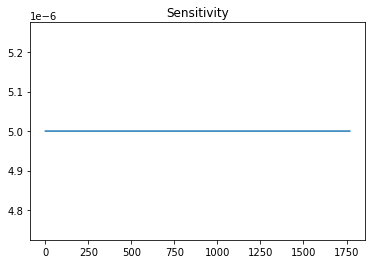

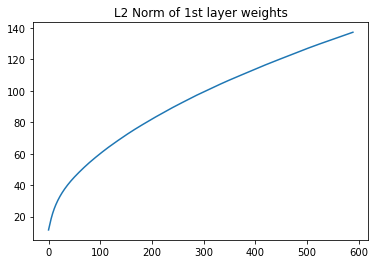

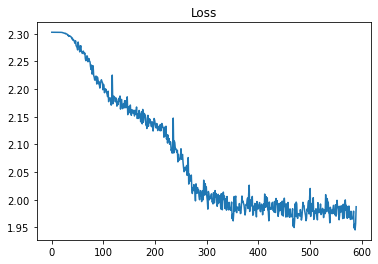


Test set: Average loss: 1.9733, Accuracy: 8768/10000 (88%)



In [15]:
model, info = run_experiment(.001, 5, False)

for key, title in [('sens', 'Sensitivity'), 
                   ('norms', 'L2 Norm of 1st layer weights'),
                   #('decays', 'Weight Decay Value'),
                   ('losses', 'Loss')
                ]:
    make_plot(info, key, title)

test(model, test_loader)

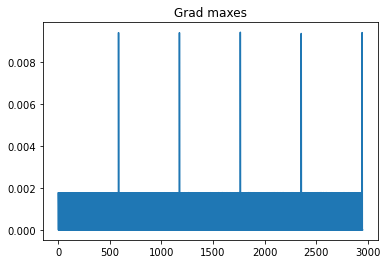

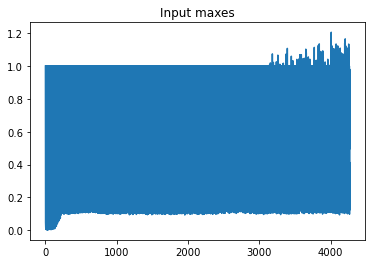

In [16]:
plt.plot(grad_maxes)
plt.title('Grad maxes')
plt.show()

plt.plot(input_maxes)
plt.title('Input maxes')
plt.show()